# OctResNet Experiments

Here we train the ResNet-18 network and a ResNet-18 network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [1]:
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
import OctResNet
%load_ext autoreload
%autoreload 2

In [2]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

Information about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [3]:
data_dir = 'tiny-imagenet-200/'

In [4]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [5]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 0


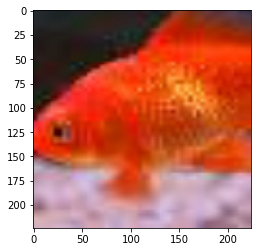

In [6]:
sample = image_datasets['train'][100]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

## Vanilla ResNet-18 Model

Here we load the ResNet-18 model from torchvision.models

## Training ResNet-18

In [19]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
train_losses = [0]
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_last = 0.0
            running_corrects = 0

            # Iterate over data.
            iter_count = 1
            for inputs, labels in dataloaders[phase]:
#                 print("Iterating over batch of size {}".format(len(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if iter_count % 50 == 0:
                    time_elapsed = time.time() - since
                    print('Average loss over iteration {} to {} =  {:.4f}'.format(iter_count - 50, iter_count, (running_loss - running_loss_last)/(iter_count*inputs.shape[0])))
                    print('Time elapsed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
                    train_losses.append((running_loss - running_loss_last)/(iter_count*inputs.shape[0]))
                    running_loss_last = running_loss
                iter_count += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
resnet18 = OctResNet.tinyoctresnet18(pretrained=False, progress=True).to(device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [22]:
train_model(resnet18, loss_fn, optimizer, num_epochs=1)

Epoch 0/0
----------
Average loss over iteration 0 to 50 =  5.6366
Time elapsed: 0m 7s
Average loss over iteration 50 to 100 =  2.9034
Time elapsed: 0m 13s
Average loss over iteration 100 to 150 =  1.8962
Time elapsed: 0m 20s
Average loss over iteration 150 to 200 =  1.4150
Time elapsed: 0m 26s
Average loss over iteration 200 to 250 =  1.1077
Time elapsed: 0m 33s
Average loss over iteration 250 to 300 =  0.9076
Time elapsed: 0m 39s
Average loss over iteration 300 to 350 =  0.7870
Time elapsed: 0m 46s
Average loss over iteration 350 to 400 =  0.6677
Time elapsed: 0m 54s
Average loss over iteration 400 to 450 =  0.5965
Time elapsed: 1m 0s
Average loss over iteration 450 to 500 =  0.5438
Time elapsed: 1m 7s
Average loss over iteration 500 to 550 =  0.4939
Time elapsed: 1m 13s
Average loss over iteration 550 to 600 =  0.4522
Time elapsed: 1m 19s
Average loss over iteration 600 to 650 =  0.4163
Time elapsed: 1m 26s
Average loss over iteration 650 to 700 =  0.3804
Time elapsed: 1m 32s
Averag

Average loss over iteration 5750 to 5800 =  0.0428
Time elapsed: 12m 34s
Average loss over iteration 5800 to 5850 =  0.0426
Time elapsed: 12m 41s
Average loss over iteration 5850 to 5900 =  0.0421
Time elapsed: 12m 47s
Average loss over iteration 5900 to 5950 =  0.0426
Time elapsed: 12m 54s
Average loss over iteration 5950 to 6000 =  0.0420
Time elapsed: 13m 0s
Average loss over iteration 6000 to 6050 =  0.0413
Time elapsed: 13m 7s
Average loss over iteration 6050 to 6100 =  0.0415
Time elapsed: 13m 13s
Average loss over iteration 6100 to 6150 =  0.0409
Time elapsed: 13m 20s
Average loss over iteration 6150 to 6200 =  0.0401
Time elapsed: 13m 26s
Average loss over iteration 6200 to 6250 =  0.0405
Time elapsed: 13m 33s
Average loss over iteration 6250 to 6300 =  0.0398
Time elapsed: 13m 40s
Average loss over iteration 6300 to 6350 =  0.0388
Time elapsed: 13m 46s
Average loss over iteration 6350 to 6400 =  0.0390
Time elapsed: 13m 53s
Average loss over iteration 6400 to 6450 =  0.0386
Ti

Average loss over iteration 11350 to 11400 =  0.0212
Time elapsed: 24m 40s
Average loss over iteration 11400 to 11450 =  0.0211
Time elapsed: 24m 47s
Average loss over iteration 11450 to 11500 =  0.0202
Time elapsed: 24m 53s
Average loss over iteration 11500 to 11550 =  0.0208
Time elapsed: 24m 59s
Average loss over iteration 11550 to 11600 =  0.0209
Time elapsed: 25m 6s
Average loss over iteration 11600 to 11650 =  0.0200
Time elapsed: 25m 12s
Average loss over iteration 11650 to 11700 =  0.0209
Time elapsed: 25m 19s
Average loss over iteration 11700 to 11750 =  0.0201
Time elapsed: 25m 25s
Average loss over iteration 11750 to 11800 =  0.0204
Time elapsed: 25m 32s
Average loss over iteration 11800 to 11850 =  0.0197
Time elapsed: 25m 38s
Average loss over iteration 11850 to 11900 =  0.0203
Time elapsed: 25m 45s
Average loss over iteration 11900 to 11950 =  0.0199
Time elapsed: 25m 51s
Average loss over iteration 11950 to 12000 =  0.0201
Time elapsed: 25m 58s
Average loss over iteratio

Average loss over iteration 16850 to 16900 =  0.0136
Time elapsed: 36m 31s
Average loss over iteration 16900 to 16950 =  0.0136
Time elapsed: 36m 38s
Average loss over iteration 16950 to 17000 =  0.0133
Time elapsed: 36m 44s
Average loss over iteration 17000 to 17050 =  0.0135
Time elapsed: 36m 51s
Average loss over iteration 17050 to 17100 =  0.0134
Time elapsed: 36m 57s
Average loss over iteration 17100 to 17150 =  0.0140
Time elapsed: 37m 4s
Average loss over iteration 17150 to 17200 =  0.0135
Time elapsed: 37m 10s
Average loss over iteration 17200 to 17250 =  0.0133
Time elapsed: 37m 17s
Average loss over iteration 17250 to 17300 =  0.0133
Time elapsed: 37m 23s
Average loss over iteration 17300 to 17350 =  0.0130
Time elapsed: 37m 30s
Average loss over iteration 17350 to 17400 =  0.0130
Time elapsed: 37m 36s
Average loss over iteration 17400 to 17450 =  0.0133
Time elapsed: 37m 43s
Average loss over iteration 17450 to 17500 =  0.0131
Time elapsed: 37m 49s
Average loss over iteratio

Average loss over iteration 22350 to 22400 =  0.0099
Time elapsed: 48m 26s
Average loss over iteration 22400 to 22450 =  0.0097
Time elapsed: 48m 32s
Average loss over iteration 22450 to 22500 =  0.0094
Time elapsed: 48m 39s
Average loss over iteration 22500 to 22550 =  0.0100
Time elapsed: 48m 46s
Average loss over iteration 22550 to 22600 =  0.0098
Time elapsed: 48m 52s
Average loss over iteration 22600 to 22650 =  0.0100
Time elapsed: 48m 58s
Average loss over iteration 22650 to 22700 =  0.0099
Time elapsed: 49m 5s
Average loss over iteration 22700 to 22750 =  0.0100
Time elapsed: 49m 12s
Average loss over iteration 22750 to 22800 =  0.0099
Time elapsed: 49m 18s
Average loss over iteration 22800 to 22850 =  0.0098
Time elapsed: 49m 25s
Average loss over iteration 22850 to 22900 =  0.0095
Time elapsed: 49m 31s
Average loss over iteration 22900 to 22950 =  0.0099
Time elapsed: 49m 38s
Average loss over iteration 22950 to 23000 =  0.0099
Time elapsed: 49m 44s
Average loss over iteratio

OctaveResNet(
  (conv1): OctConv2dStackable(
    (conv_hh): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv_hl): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  )
  (bnLow): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnHigh): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1bn): OctConv2dBN(
        (conv_hh): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_ll): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_lh): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (upsample): Upsample(scale_factor=2.0, mode=nearest)
        (conv_hl): Conv2d(48, 16, kernel_s

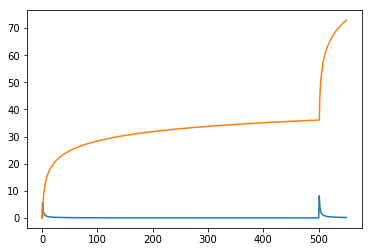

In [26]:
plt.plot(train_losses)
actual_train_losses = [np.sum(train_losses[:i]) for i in range(len(train_losses))]
plt.plot(actual_train_losses)
plt.show()

In [24]:
#Save model?
torch.save(model.state_dict(), './best_oct_model.wts')

NameError: name 'model' is not defined

In [27]:
print(torch.cuda.max_memory_allocated(device))
print(torch.cuda.get_device_capability(device))

1190210048
(3, 7)
